In [1]:
import torch
import torchvision
import torchaudio
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [ ]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:!wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg


--2024-09-20 11:01:26--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 13.35.7.12, 13.35.7.36, 13.35.7.124, ...
Connecting to segment-anything.com (segment-anything.com)|13.35.7.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.01s   

2024-09-20 11:01:27 (17.7 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [ ]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


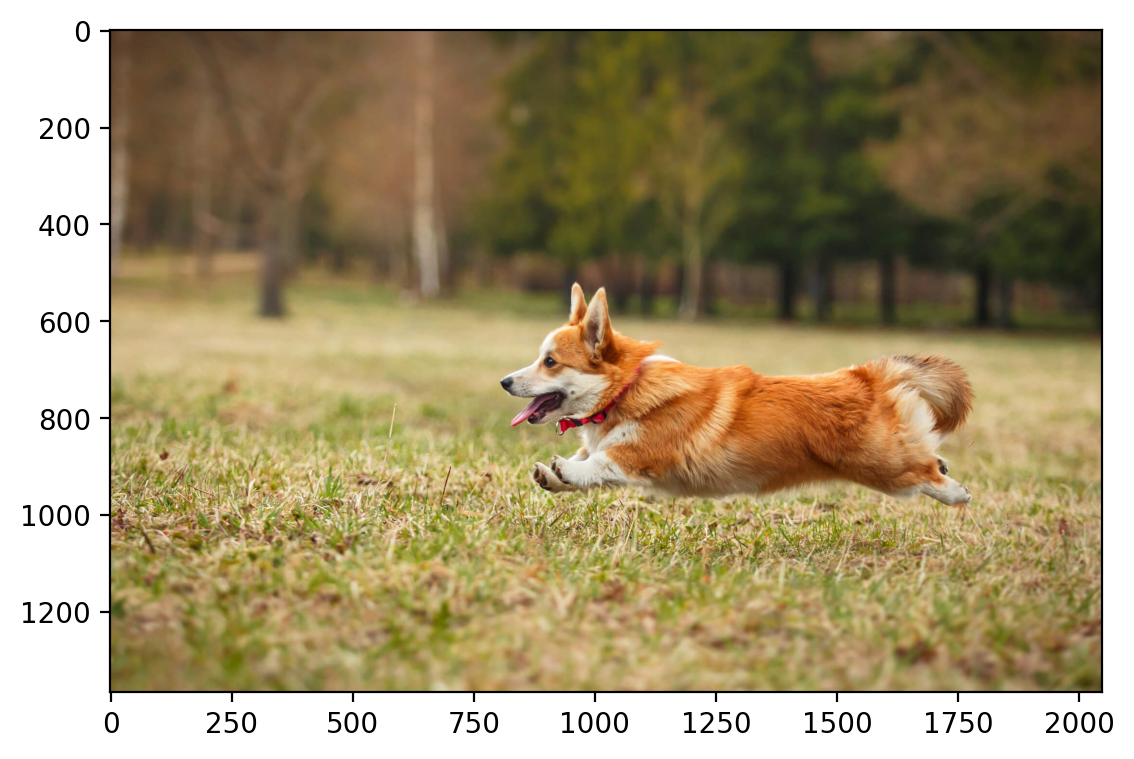

In [ ]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


In [ ]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [ ]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [ ]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [ ]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop.shape

torch.Size([3, 300, 300])

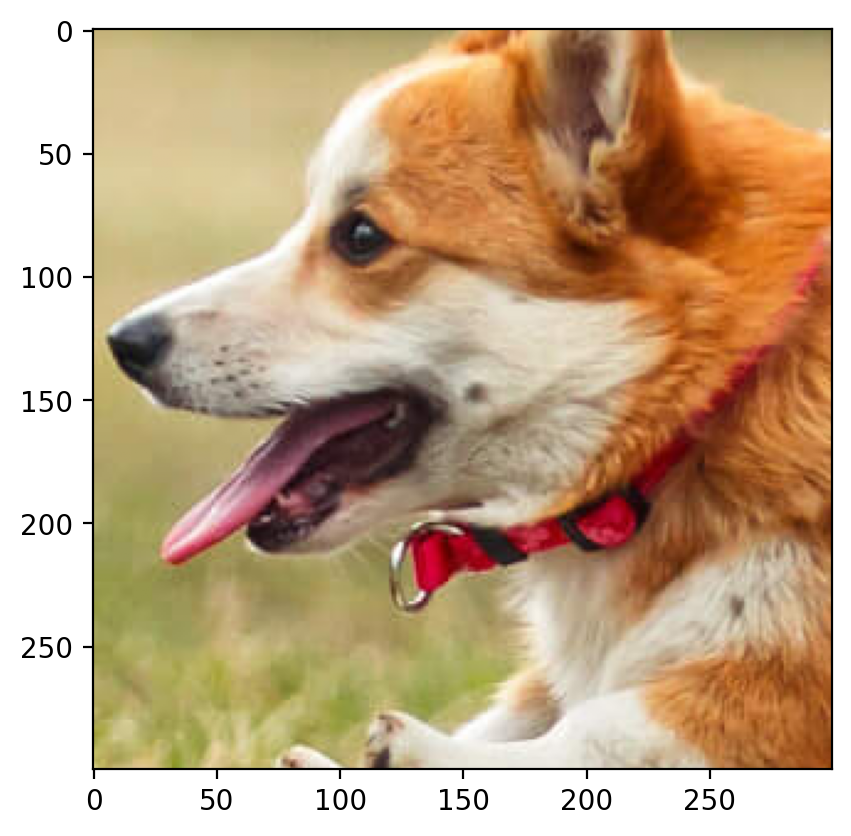

In [ ]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())


In [ ]:
crop = crop.to(device)


In [ ]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [ ]:
num_channels, height, width = 2, 3, 4


# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [ ]:
X.shape

torch.Size([12, 2])

In [ ]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [ ]:
dog_X, dog_Y = create_coordinate_map(crop, scale=1)

dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [ ]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [2]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [3]:
device

device(type='cuda')

In [4]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [ ]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [5]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)


In [ ]:
X_rff = create_rff_features(dog_X_scaled, 16000, 0.008)

In [ ]:
X_rff.shape

torch.Size([90000, 16000])

In [ ]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)


LinearModel(
  (linear): Linear(in_features=16000, out_features=3, bias=True)
)

In [ ]:
train(net, 0.005, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.379011
Epoch 100 loss: 0.056746
Epoch 200 loss: 0.017105
Epoch 300 loss: 0.011534
Epoch 400 loss: 0.009053
Epoch 500 loss: 0.007368
Epoch 600 loss: 0.006104
Epoch 700 loss: 0.005107
Epoch 800 loss: 0.004298
Epoch 900 loss: 0.003634
Epoch 1000 loss: 0.003083
Epoch 1100 loss: 0.002626
Epoch 1200 loss: 0.002246
Epoch 1300 loss: 0.001930
Epoch 1400 loss: 0.001668
Epoch 1500 loss: 0.001451
Epoch 1600 loss: 0.001272
Epoch 1700 loss: 0.001125
Epoch 1800 loss: 0.001005
Epoch 1900 loss: 0.000906
Epoch 2000 loss: 0.000826
Epoch 2100 loss: 0.000761
Epoch 2200 loss: 0.000708
Epoch 2300 loss: 0.000665
Epoch 2400 loss: 0.000630


0.000601715175434947

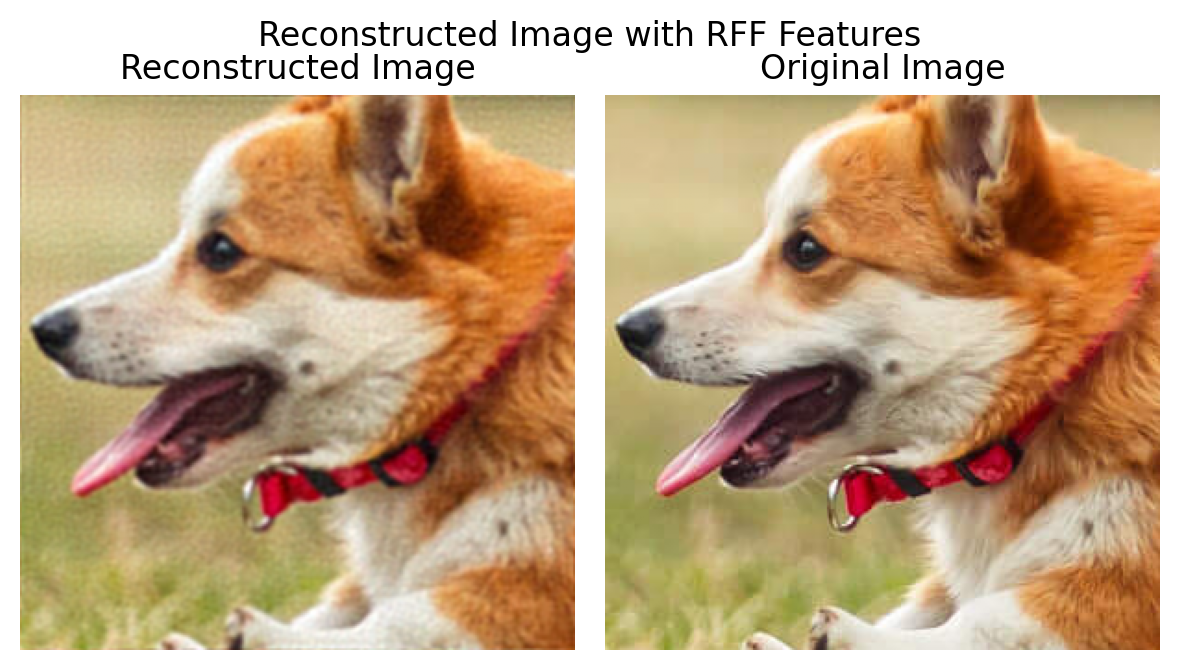

In [ ]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [ ]:
import numpy as np

def calculate_mse(original, reconstructed):
    """
    Calculate the Mean Squared Error (MSE) between the original and reconstructed images.
    """
    # Convert PyTorch tensors to NumPy arrays if necessary
    if isinstance(original, torch.Tensor):
        original = original.cpu().numpy()
    if isinstance(reconstructed, torch.Tensor):
        reconstructed = reconstructed.cpu().numpy()
    mse = np.mean((original - reconstructed) ** 2)
    return mse

def calculate_psnr(original, reconstructed):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.
    """
    mse = calculate_mse(original, reconstructed)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0  # Assuming the pixel values range from 0 to 255
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr
num_channels, height, width = crop.shape
net.eval()
with torch.no_grad():
        outputs = net(X_rff)
        print(outputs.shape)
        outputs = outputs.reshape(height, width, num_channels)
        outputs = outputs.permute(2, 0, 1)
        reconstructed_img = outputs.to(device)
print(crop.shape, reconstructed_img.shape)
print(crop.device, reconstructed_img.device)
mse = calculate_mse(crop, reconstructed_img.float())
psnr = calculate_psnr(crop, reconstructed_img.float())

print(f"MSE: {mse}")
print(f"PSNR: {psnr} dB")

torch.Size([90000, 3])
torch.Size([3, 300, 300]) torch.Size([3, 300, 300])
cuda:0 cuda:0
MSE: 0.0006014606745632915
PSNR: 80.33873123836241 dB


In [6]:
if os.path.exists('download.mp3'):
    print('download.mp3 exists')
else:
  !wget https://cdn.pixabay.com/audio/2021/11/01/audio_00fa5593f3.mp3 -O download.mp3


--2024-09-20 14:26:24--  https://cdn.pixabay.com/audio/2021/11/01/audio_00fa5593f3.mp3
Resolving cdn.pixabay.com (cdn.pixabay.com)... 172.64.147.160, 104.18.40.96, 2606:4700:4400::ac40:93a0, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|172.64.147.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5838889 (5.6M) [audio/mpeg]
Saving to: ‘download.mp3’

download.mp3        100%[===================>]   5.57M  --.-KB/s    in 0.06s   

2024-09-20 14:26:24 (101 MB/s) - ‘download.mp3’ saved [5838889/5838889]



In [7]:
# %pip install pygobject playsound
# import playsound
# Read in an audio file using torchaudio.load
waveform, sample_rate = torchaudio.load("download.mp3")
# Calculate the number of frames for 5 seconds
num_frames = int(5 * sample_rate)

# Trim the audio to the first 5 seconds
trimmed_waveform = waveform[:, :num_frames]

# Print the shape of the trimmed waveform
print(trimmed_waveform.shape)
print(trimmed_waveform.dtype)
torchaudio.save("trimmed_waveform.wav", trimmed_waveform, sample_rate)
# playsound.playsound("trimmed_waveform.wav")

torch.Size([2, 220500])
torch.float32


In [8]:
from IPython.display import Audio
Audio('trimmed_waveform.wav')

In [9]:
audio_data = trimmed_waveform.numpy()
print(audio_data)
audio_data=audio_data[0]
print(audio_data)
X = torch.arange(0, len(audio_data)).unsqueeze(1).float()
X = X / X.max() * 200 - 100
X = X.numpy()
print(X.shape)
print(X)

[[0.         0.         0.         ... 0.02239625 0.02815863 0.03262083]
 [0.         0.         0.         ... 0.0649206  0.08314396 0.09644881]]
[0.         0.         0.         ... 0.02239625 0.02815863 0.03262083]
(220500, 1)
[[-100.      ]
 [ -99.99909 ]
 [ -99.998184]
 ...
 [  99.998184]
 [  99.9991  ]
 [ 100.      ]]


In [10]:
def audio_plot(audio, sr, clr, tl):
    plt.figure(figsize=(15, 4))
    plt.plot(audio, color = clr, alpha = 0.7)
    plt.xticks(np.arange(0, audio.shape[0], sr), np.arange(0, audio.shape[0] / sr, 1))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(tl)
    plt.grid()
    plt.show()

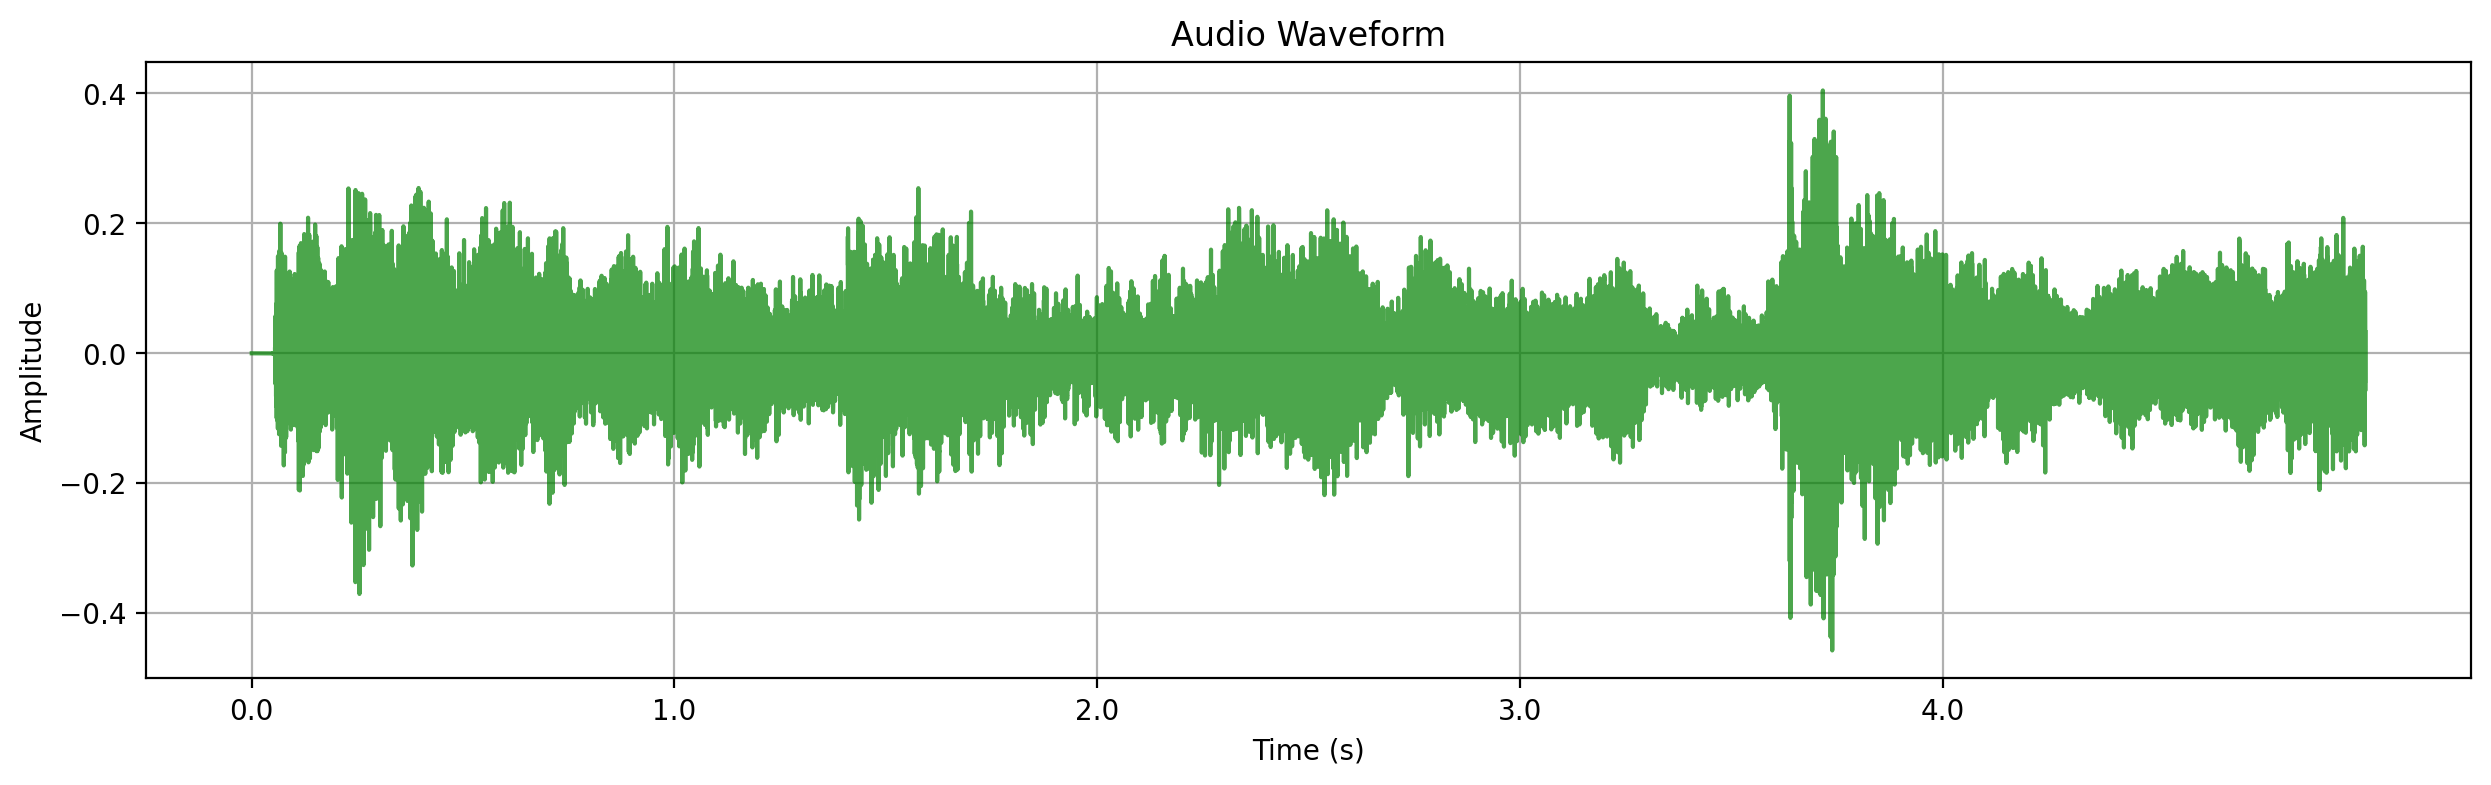

In [11]:
audio_plot(audio_data, sample_rate, 'green', 'Audio Waveform')

In [13]:
X.shape, audio_data.shape

((220500, 1), (220500,))

In [14]:
X_rff = create_rff_features(X, 4000, 0.008)

In [15]:
X_rff.shape

torch.Size([220500, 4000])

In [17]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_rff.numpy(), audio_data)

pred_audio = model.predict(X_rff)
print(pred_audio.shape)

(220500,)


In [18]:
import soundfile as sf
sf.write('pred_audio.wav', pred_audio, sample_rate)

In [19]:
Audio('pred_audio.wav')

In [20]:
import numpy as np

def calculate_mse(original, reconstructed):
    """
    Calculate the Mean Squared Error (MSE) between the original and reconstructed images.
    """
    # Convert PyTorch tensors to NumPy arrays if necessary
    if isinstance(original, torch.Tensor):
        original = original.cpu().numpy()
    if isinstance(reconstructed, torch.Tensor):
        reconstructed = reconstructed.cpu().numpy()
    mse = np.mean((original - reconstructed) ** 2)
    return mse

def calculate_psnr(original, reconstructed):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.
    """
    mse = calculate_mse(original, reconstructed)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0  # Assuming the pixel values range from 0 to 255
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

mse = calculate_mse(audio_data, pred_audio)
psnr = calculate_psnr(audio_data, pred_audio)

print(f"MSE: {mse}")
print(f"PSNR: {psnr} dB")

MSE: 0.0028731846250593662
PSNR: 73.54716821397847 dB
